# Image Quality Analysis

This notebook loads two datasets of fossil images for quality analysis:

- **OVC dataset**: images from Oervondstchecker (e.g. `images_ovc/`)
- **NBC dataset**: research grade images from Naturalis (e.g. `images_nbc/`)

OVC images found: 118
NBC images found: 118


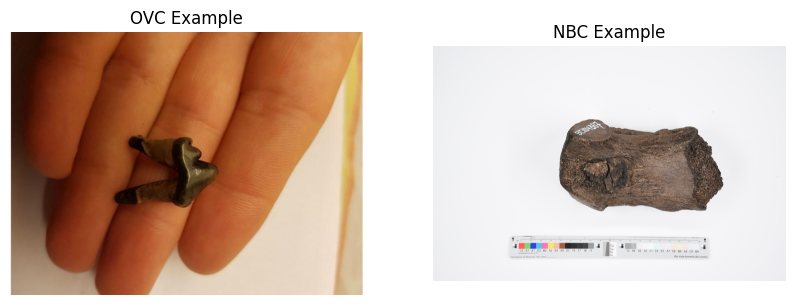

In [14]:
import os
from glob import glob

# Set dataset folders
ovc_folder = 'images_ovc'
nbc_folder = 'images_nbc'

# Get image file lists
ovc_images = sorted(glob(os.path.join(ovc_folder, '*')))
nbc_images = sorted(glob(os.path.join(nbc_folder, '*')))

print(f'OVC images found: {len(ovc_images)}')
print(f'NBC images found: {len(nbc_images)}')

# Show first image from each dataset
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('OVC Example')
plt.imshow(Image.open(ovc_images[0]))
plt.axis('off')

plt.subplot(1,2,2)
plt.title('NBC Example')
plt.imshow(Image.open(nbc_images[0]))
plt.axis('off')
plt.show()

In [15]:
# --- Basic image statistics for each dataset ---
import numpy as np


def get_basic_stats(img_list):
    widths, heights, aspect_ratios = [], [], []
    for path in img_list:
        try:
            img = Image.open(path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
            aspect_ratios.append(w / h if h != 0 else float('nan'))
        except Exception:
            widths.append(float('nan'))
            heights.append(float('nan'))
            aspect_ratios.append(float('nan'))
    return {
        "width": widths,
        "height": heights,
        "aspect_ratio": aspect_ratios
    }

ovc_stats = get_basic_stats(ovc_images)
nbc_stats = get_basic_stats(nbc_images)

print("OVC Image Stats:")
print(f"  Mean width: {np.nanmean(ovc_stats['width']):.1f}")
print(f"  Mean height: {np.nanmean(ovc_stats['height']):.1f}")
print(f"  Mean aspect ratio (w/h): {np.nanmean(ovc_stats['aspect_ratio']):.2f}")

print("\nNBC Image Stats:")
print(f"  Mean width: {np.nanmean(nbc_stats['width']):.1f}")
print(f"  Mean height: {np.nanmean(nbc_stats['height']):.1f}")
print(f"  Mean aspect ratio (w/h): {np.nanmean(nbc_stats['aspect_ratio']):.2f}")


OVC Image Stats:
  Mean width: 710.0
  Mean height: 530.0
  Mean aspect ratio (w/h): 1.34

NBC Image Stats:
  Mean width: 6016.0
  Mean height: 4016.0
  Mean aspect ratio (w/h): 1.50


## Compute BRISQUE and more for OVC and NBC datasets

In [ ]:
import cv2
import numpy as np
import piq
from PIL import Image
from scipy.fft import fftshift
from scipy.fftpack import fft2
import torch
import torchvision.transforms as T
from skimage import io
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy


def calculate_sharpness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return float('nan')
    return cv2.Laplacian(img, cv2.CV_64F).var()

def calculate_entropy(img_path):
    img = io.imread(img_path)
    gray = rgb2gray(img)
    return shannon_entropy(gray)

def calculate_colorfulness(img_path):
    img = cv2.imread(img_path)
    if img is None: return float('nan')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    (R, G, B) = cv2.split(img.astype("float"))
    rg = np.absolute(R - G)
    yb = np.absolute(0.5*(R + G) - B)
    std_root = np.sqrt((rg.std()**2) + (yb.std()**2))
    mean_root = np.sqrt((rg.mean()**2) + (yb.mean()**2))
    return std_root + (0.3 * mean_root)

def calculate_snr(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return float('nan')
    mean = np.mean(img)
    std = np.std(img)
    return 0 if std == 0 else mean / std

def calculate_fft_sharpness(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return float('nan')
    f = np.abs(fftshift(fft2(img)))
    h, w = img.shape
    crow, ccol = h//2, w//2
    high_freq = f[crow-50:crow+50, ccol-50:ccol+50]  # center = low freq
    return np.sum(f) - np.sum(high_freq)

def get_scores(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
    except Exception:
        return [float('nan')]*5

    transform = T.ToTensor()
    img_tensor = transform(img).unsqueeze(0)

    # BRISQUE
    try:
        brisque_score = piq.brisque(img_tensor).item()
    except Exception:
        brisque_score = float('nan')

    return [
        brisque_score,
        calculate_sharpness(img_path),
        calculate_fft_sharpness(img_path),
        calculate_entropy(img_path),
        calculate_colorfulness(img_path),
        calculate_snr(img_path)
    ]

# ---- Process datasets ----
metrics_names = ["BRISQUE", "Sharpness", "FFT Sharpness", "Entropy", "Colorfulness", "SNR Signal-to-Noise Ratio"]

def process_dataset(img_list):
    results = {name: [] for name in metrics_names}
    for path in img_list:
        scores = get_scores(path)
        for name, val in zip(metrics_names, scores):
            results[name].append(val)
    return results

ovc_results = process_dataset(ovc_images)
nbc_results = process_dataset(nbc_images)

# ---- Print averages ----
print("OVC Averages:")
for m in metrics_names:
    print(f"{m}: {np.nanmean(ovc_results[m]):.3f}")

print("\nNBC Averages:")
for m in metrics_names:
    print(f"{m}: {np.nanmean(nbc_results[m]):.3f}")


TypeError: calculate_fft_sharpness() missing 1 required positional argument: 'metrics'

### Output Explanation

The printed averages summarize the image quality metrics for the OVC (citizen science) and NBC (research grade) fossil image datasets:

- **BRISQUE:** Lower values indicate better perceptual image quality. NBC images (31.3) have better quality than OVC images (41.9).
- **Sharpness:** Higher values indicate sharper images. OVC images (507.8) are much sharper than NBC images (25.3), which may be due to differences in image resolution or focus or background detail.
- **Entropy:** Measures image complexity; higher values mean more texture and detail. Both datasets have similar entropy.
- **Colorfulness:** Higher values indicate more vivid colors. OVC images (35.3) are more colorful than NBC images (25.7).
- **SNR (Signal-to-Noise Ratio):** Higher values indicate less noise. NBC images (6.2) are less noisy than OVC images (2.6).

**Summary:**  
NBC images generally have better perceptual quality and less noise, while OVC images are sharper and more colorful. These differences reflect the distinct imaging conditions and standards of each dataset.

## Visualize average image quality metrics

Note: you may need to restart the kernel to use updated packages.


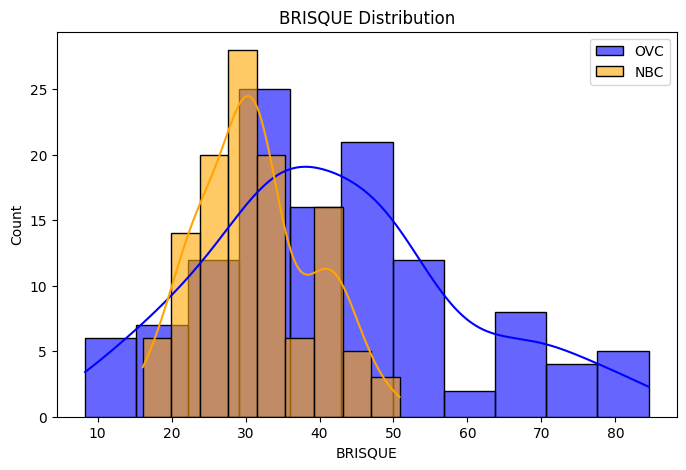

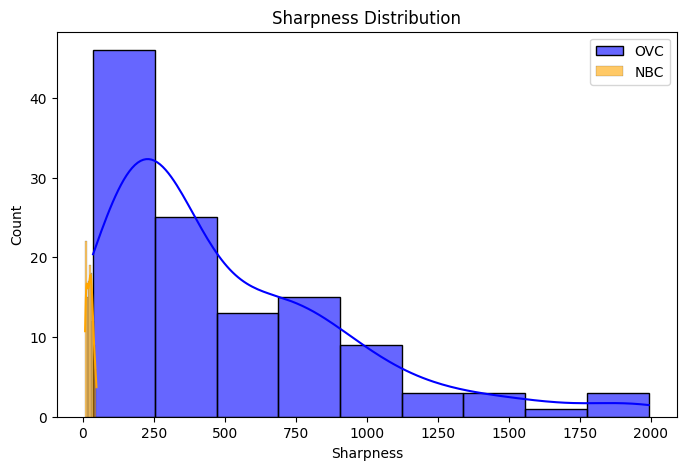

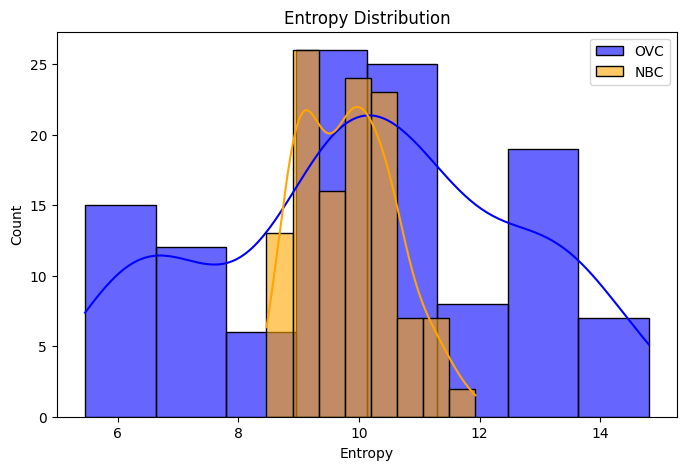

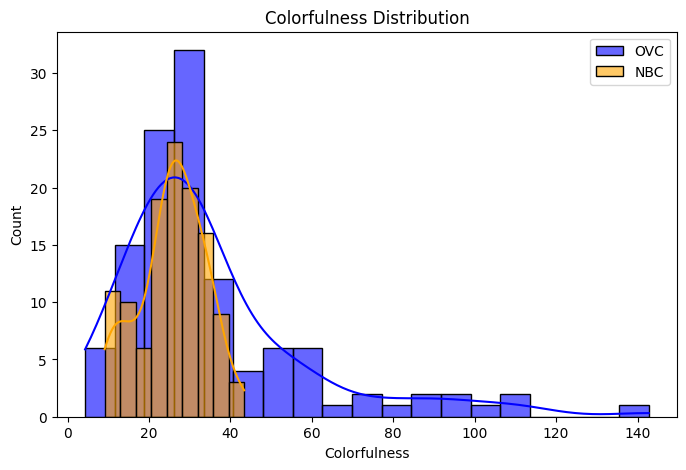

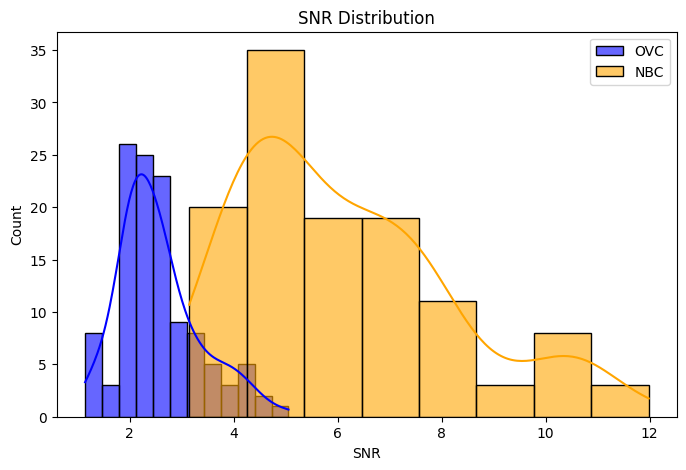

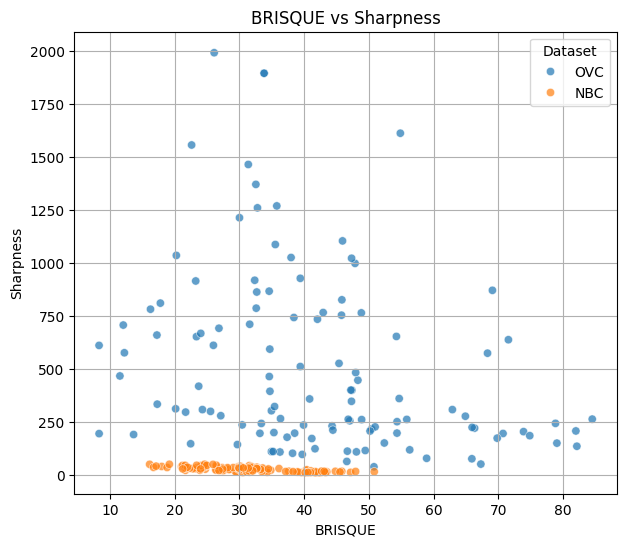

In [ ]:
%pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame for seaborn
def results_to_df(results, label):
    df = pd.DataFrame(results)
    df["Dataset"] = label
    return df

df_ovc = results_to_df(ovc_results, "OVC")
df_nbc = results_to_df(nbc_results, "NBC")
df_all = pd.concat([df_ovc, df_nbc])


# --- Histograms ---
for m in metrics_names:
    plt.figure(figsize=(8,5))
    sns.histplot(df_all[df_all["Dataset"]=="OVC"][m], label="OVC", kde=True, color="blue", alpha=0.6)
    sns.histplot(df_all[df_all["Dataset"]=="NBC"][m], label="NBC", kde=True, color="orange", alpha=0.6)
    plt.title(f"{m} Distribution")
    plt.xlabel(m)
    plt.legend()
    plt.show()

# --- Scatter plot: BRISQUE vs Sharpness ---
plt.figure(figsize=(7,6))
sns.scatterplot(data=df_all, x="BRISQUE", y="Sharpness", hue="Dataset", alpha=0.7)
plt.title("BRISQUE vs Sharpness")
plt.grid(True)
plt.show()



C:\Users\megan\AppData\Local\Temp\ipykernel_13776\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


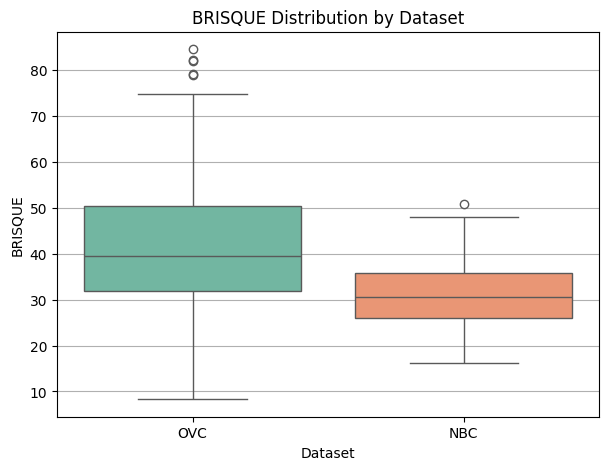

C:\Users\megan\AppData\Local\Temp\ipykernel_13776\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


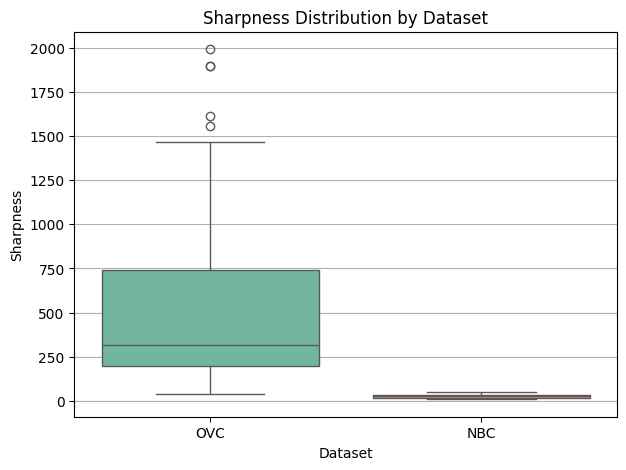

C:\Users\megan\AppData\Local\Temp\ipykernel_13776\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


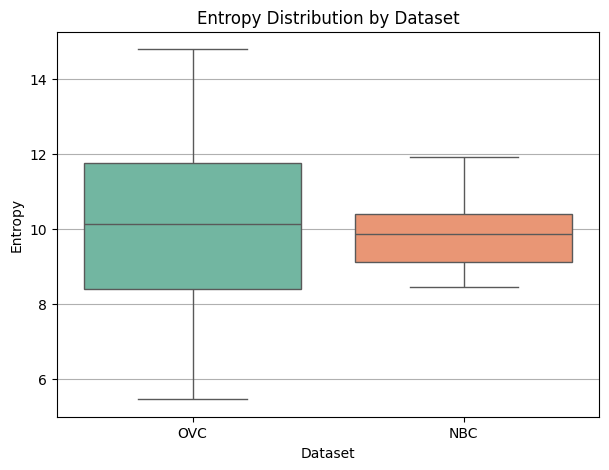

C:\Users\megan\AppData\Local\Temp\ipykernel_13776\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


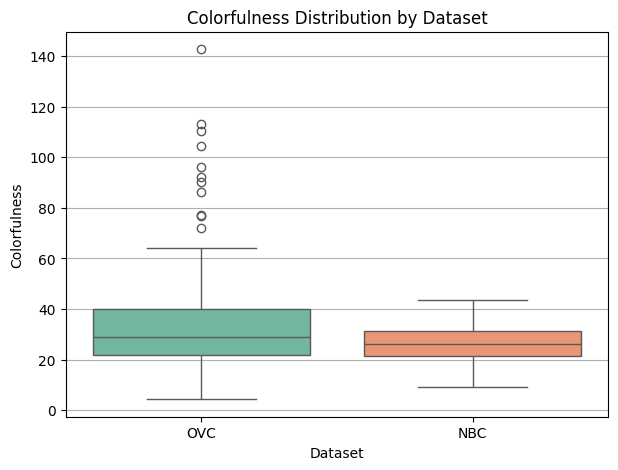

C:\Users\megan\AppData\Local\Temp\ipykernel_13776\2408311887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")


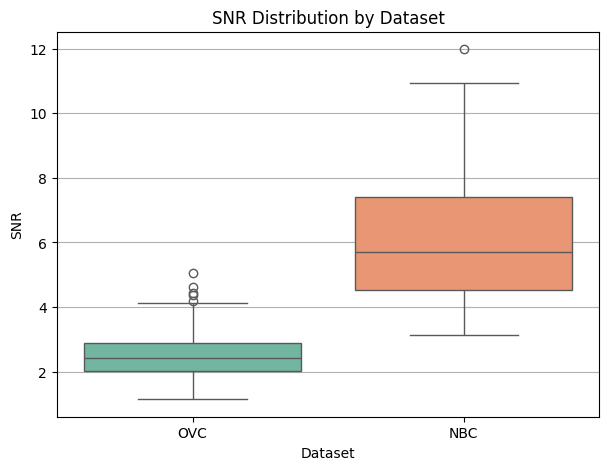

In [ ]:
# --- Single boxplots for each metric ---
for metric in metrics_names:
    plt.figure(figsize=(7,5))
    sns.boxplot(x="Dataset", y=metric, data=df_all, palette="Set2")
    plt.title(f"{metric} Distribution by Dataset")
    plt.ylabel(metric)
    plt.grid(True, axis="y")
    plt.show()

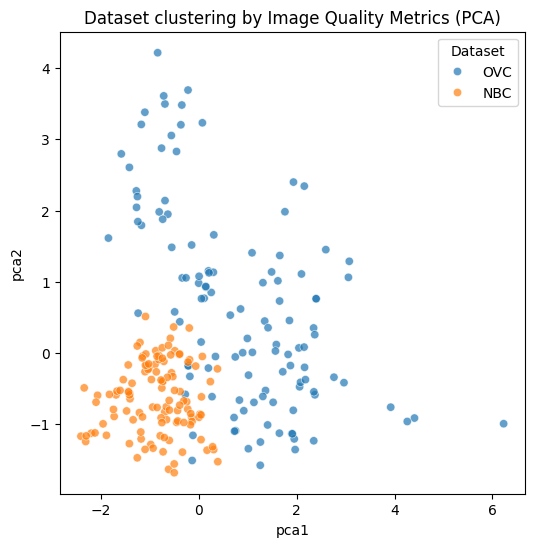

In [ ]:

# PCA clustering of metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_all[metrics_names].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_all["pca1"], df_all["pca2"] = pca_result[:,0], pca_result[:,1]

plt.figure(figsize=(6,6))
sns.scatterplot(x="pca1", y="pca2", hue="Dataset", data=df_all, alpha=0.7)
plt.title("Dataset clustering by Image Quality Metrics (PCA)")
plt.show()


#### PCA stands for Principal Component Analysis.
It is a dimensionality reduction technique that transforms multiple correlated metrics into a few uncorrelated "principal components" that capture most of the variance in the data.

In the diagram:

Each point represents an image, plotted by its values on the first two principal components (pca1 and pca2).
Images from the NBC and OVC datasets are shown in different colors.
The clustering shows that NBC and OVC images have distinct quality profiles based on all measured metrics (sharpness, entropy, contrast, noise, illumination uniformity).
PCA helps visualize how well the metrics separate the two datasets.